# SOLVED TROUBLE SHOOT Tracking using image features

Testing the Elliptical Fourier Descriptors (EFD) similarity between instances of cells

In [1]:
import dask.array as da
import napari
import btrack
from tqdm.auto import tqdm
import skimage
from skimage.io import imshow,  imsave
import matplotlib.pyplot as plt
import numpy as np
from pyefd import elliptic_fourier_descriptors
plt.rcParams["figure.figsize"] = (15,15)

### Load images from zarr and compress into max projections

In [2]:
gfp = da.from_zarr('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch1.zarr/')
rfp = da.from_zarr('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch2.zarr/')
gfp = da.sum(gfp, axis = 1, dtype='u2')
rfp = da.sum(rfp, axis = 1, dtype='u2')
masks = da.from_zarr(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch99.zarr/',)# chunks = gfp.chunks)

#### Compress into multichannel image for btrack

In [3]:
image = da.stack([gfp, rfp], axis = -1)
image

dask.array<stack, shape=(75, 6048, 6048, 2), dtype=uint16, chunksize=(1, 2160, 2160, 1), chunktype=numpy.ndarray>

## Define features

In [4]:
FEATURES = [
  "area",
  "major_axis_length",
  "minor_axis_length",
  "orientation",
  "solidity",
  "mean_intensity",
    "intensity_image"
]

In [5]:
objects = btrack.utils.segmentation_to_objects(
    masks[0:2], 
    image[0:2],
    properties = tuple(FEATURES),
    use_weighted_centroid = False, 
)

[INFO][2022/11/11 12:58:32 PM] Localizing objects from segmentation...
[INFO][2022/11/11 12:58:32 PM] Found intensity_image data
[INFO][2022/11/11 12:58:50 PM] Objects are of type: <class 'dict'>
[INFO][2022/11/11 12:58:50 PM] ...Found 1254 objects in 2 frames.


#### Checking number of objects localised

In [8]:
len(objects)

1254

and per frame

In [9]:
len([obj for obj in objects if obj.t == 0]), len([obj for obj in objects if obj.t == 1]), 

(639, 615)

now checking the number of masks in an image

In [13]:
masks[0]

dask.array<getitem, shape=(6048, 6048), dtype=uint16, chunksize=(2160, 2160), chunktype=numpy.ndarray>

In [14]:
np.max(masks[0].compute())

622

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


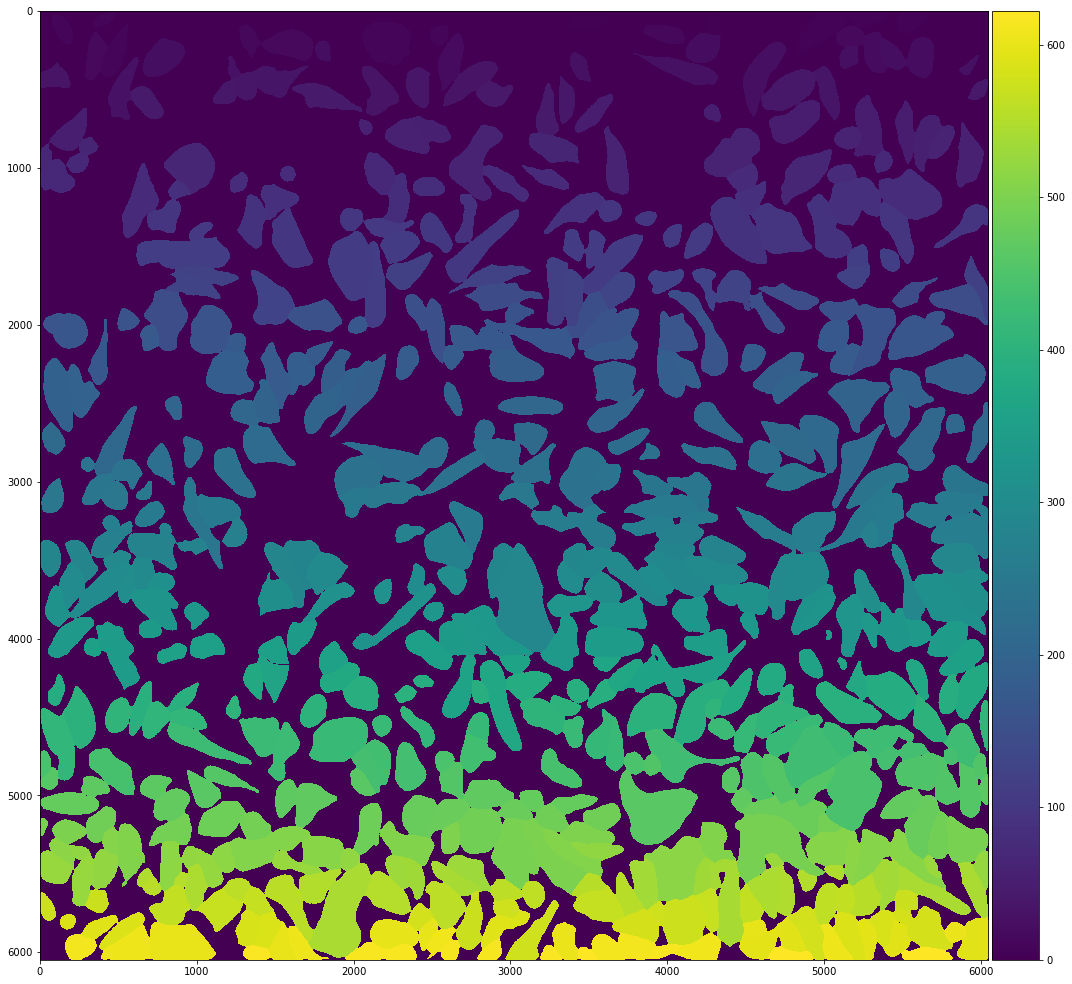

In [15]:
imshow(masks[0])

In [7]:
### finding the EFD
for obj in tqdm(objects):
    ### extract the intensity image (1ch only)
    glimpse = obj.properties['intensity_image'][...,0]
    ### pad the glimpse to ensure only one object is identifiable
    glimpse = np.pad(glimpse, pad_width = 1)
    ### find the contours (zero because only one object)
    contours = skimage.measure.find_contours(glimpse, fully_connected='high', level = 0.5)[0]
    ### get the efd
    efd = elliptic_fourier_descriptors(contours, order=100, normalize=True)
#     obj.properties = {'efd': efd}
    flatten_efd = efd.flatten()
    obj.properties = {'efd flat': flatten_efd}

  0%|          | 0/69608 [00:00<?, ?it/s]

## Remove intensity image from objects 

btrack does not handle 2d arrays in objects

In [8]:
for obj in tqdm(objects):
    obj.properties.pop('intensity_image')

  0%|          | 0/69608 [00:00<?, ?it/s]

In [9]:
objects[0]

{'ID': 0, 'x': 228.89178743961352, 'y': 53.54589371980676, 'z': 0.0, 't': 0, 'dummy': False, 'states': 7, 'label': 5, 'area': 8280, 'major_axis_length': 142.1681837092044, 'minor_axis_length': 74.98138905075203, 'orientation': 0.7685315327700352, 'solidity': 0.9757247230732972, 'mean_intensity-0': 1223.1384057971015, 'mean_intensity-1': 337.88864734299517, 'efd flat': array([ 1.00000000e+00,  5.04301835e-17,  1.14701462e-16, -6.09709389e-01,
        2.01976227e-02,  8.87153725e-03, -4.89990443e-02, -2.30932987e-02,
        4.96015509e-02,  2.22684140e-03,  1.97777233e-02, -6.52375860e-02,
       -1.61762974e-03,  4.21390024e-03,  6.80647690e-04, -3.76505429e-03,
        1.05512406e-02, -4.07975839e-04,  5.86517107e-04, -9.60494084e-03,
       -6.98005603e-03,  5.03815140e-03, -9.67077973e-04,  7.75433259e-03,
        3.51114072e-03, -6.58337802e-03, -1.87062801e-03,  3.27958217e-03,
        3.22977869e-04,  8.28085673e-03,  6.93344800e-03, -2.27455131e-03,
       -1.19519206e-03, -7.04011333e-03, -4.47416433e-03,  3.10420744e-04,
        2.68803249e-03,  5.93816998e-03,  2.13798631e-03,  1.03867541e-03,
       -2.72036474e-03, -3.42627101e-03,  1.01166469e-03, -1.39096609e-03,
        1.86584384e-03,  2.29004954e-03, -2.83302613e-03, -2.34922322e-04,
       -4.72931407e-04, -1.01812765e-03,  2.81674483e-03, -7.07489089e-04,
       -1.66482600e-03,  2.02827423e-03, -1.54457356e-04, -1.29588986e-03,
        2.57490199e-03, -1.27656143e-03, -1.81186695e-03,  2.07572955e-03,
       -1.41233818e-03,  1.42119967e-03,  2.51444308e-03, -1.29947872e-04,
        1.59962205e-03, -1.33302262e-03, -9.23309588e-04,  5.43618873e-05,
        2.62620014e-04,  1.01734811e-03, -1.03857862e-03,  1.52913514e-03,
        2.00747585e-04, -1.04091945e-04,  9.12398983e-04, -1.58627506e-03,
        8.68560221e-04, -6.04671434e-04, -1.77728274e-05, -2.21296486e-04,
       -1.15549792e-04,  1.03128782e-03,  1.79668554e-04,  6.31632075e-04,
        8.51758725e-04, -1.72974649e-03,  3.90995491e-04, -7.14500934e-04,
        1.16578563e-04,  1.05820726e-03, -6.81204958e-04,  1.28597457e-03,
        7.14805518e-04, -1.04273041e-03,  1.01359713e-03, -8.47485901e-04,
       -2.51396246e-04,  7.68356581e-04,  1.64672708e-04, -1.10066311e-03,
        8.92798183e-04, -3.29990031e-04, -8.54309126e-04,  1.10377098e-03,
       -1.01218781e-03,  4.28701126e-04,  2.83842823e-04, -3.14728090e-04,
        1.01534709e-03, -1.09306163e-04, -6.17853094e-04, -6.09944737e-04,
       -5.06543474e-04,  1.79488309e-04,  1.10643996e-03,  7.61548988e-04,
        4.21945913e-04,  5.31384440e-04,  7.53410906e-04,  2.03385206e-04,
       -5.08070414e-04, -2.86505392e-04, -2.20785493e-03,  1.94249606e-04,
        3.41898620e-04,  7.15824486e-04,  3.38721489e-05, -2.49267270e-04,
       -2.64607459e-04, -2.79842118e-04,  8.67219527e-04, -4.40285781e-04,
        5.34562152e-04,  1.63838452e-04,  7.29208121e-05,  2.47532970e-04,
        5.95851673e-05, -1.30993651e-04,  1.09116154e-03,  1.81898748e-04,
       -5.89545242e-04, -4.73526996e-04, -5.71898285e-04, -6.34270107e-04,
        8.99264166e-04, -5.06610494e-05, -1.67433931e-04, -1.99754939e-04,
       -6.11627418e-04, -2.14649652e-04,  5.60688844e-04,  4.48659166e-04,
        8.48051633e-04, -7.52024107e-04, -3.13138790e-04,  5.43722767e-05,
        1.21816208e-04,  7.53054683e-05,  3.18770775e-04,  7.02679137e-04,
        2.66734339e-04,  3.98417069e-05, -7.84266023e-05,  1.75608196e-04,
        6.44278393e-04, -5.46194395e-04, -8.14276429e-04, -4.19748909e-04,
        1.01580143e-04,  6.95019509e-04,  6.63031624e-04,  2.85621415e-04,
        1.87573001e-04, -6.32407813e-04, -1.13149742e-03, -3.78375538e-04,
        2.62121041e-04,  8.45593956e-04, -1.95384741e-05, -6.14103573e-04,
       -7.96252846e-05, -5.94504741e-05,  5.02920925e-04,  8.19084506e-04,
       -6.12751645e-05,  1.25976584e-04, -3.80003191e-04, -1.20860318e-03,
        1.44873222e-04,  6.53646454e-04,  8.17380757e-04, -2.40791973e-04,
       -8.20519315e-04, -1.57

## Track

Redefine features to include `efd flat` and the two different `mean_intensity` channels

In [12]:
FEATURES = ['efd flat',
                     "area",
  "major_axis_length",
  "minor_axis_length",
  "orientation",
  "solidity",
  "mean_intensity-0",
  "mean_intensity-1",
]

In [13]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config file
    tracker.configure_from_file(
        '/home/dayn/analysis/BayesianTracker/models/particle_config.json'
    )
    tracker.verbose = True

    tracker.max_search_radius = 400
    
    # use visual features to track
    tracker.features = FEATURES
    
    # append the objects to be tracked
    tracker.append(objects)

    # set the volume
    tracker.volume=((0, 6048), (0, 6048), (-1e5, 1e5))

    # track them (in interactive mode)
    tracker.track_interactive(step_size=25)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

    tracker.export(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tracks.h5', obj_type='obj_type_1')

#     # get the tracks in a format for napari visualization (optional)
    visualise_tracks, properties, graph = tracker.to_napari(ndim=2)
    
    tracks = tracker.tracks

[INFO][2022/11/11 10:35:03 AM] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/11/11 10:35:03 AM] btrack (v0.5.0) library imported
[INFO][2022/11/11 10:35:03 AM] Starting BayesianTracker session
[INFO][2022/11/11 10:35:03 AM] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/particle_config.json
[INFO][2022/11/11 10:35:03 AM] Setting max_search_radius -> 400
[INFO][2022/11/11 10:35:03 AM] Setting features -> ['efd flat', 'area', 'major_axis_length', 'minor_axis_length', 'orientation', 'solidity', 'mean_intensity-0', 'mean_intensity-1']
[INFO][2022/11/11 10:35:03 AM] Objects are of type: <class 'list'>
[INFO][2022/11/11 10:35:05 AM] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/11/11 10:35:05 AM] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/11/11 10:35:05 AM] Starting tracking... 
[INFO][2022/11/11 10:35:05 AM] Update using: ['MOTION']
[INFO][2022/11/11 10:35:07 AM]

GLPK Integer Optimizer 5.0
166804 rows, 153696 columns, 223990 non-zeros
153696 integer variables, all of which are binary
Preprocessing...
83402 rows, 153696 columns, 223990 non-zeros
153696 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 83402
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
83402 rows, 153696 columns, 223990 non-zeros
*     0: obj =   5.202398577e+05 inf =   0.000e+00 (63402)
Perturbing LP to avoid stalling [1499]...
*  1568: obj =   5.029140210e+05 inf =   0.000e+00 (61596)
*  3342: obj =   4.861981039e+05 inf =   0.000e+00 (59517)
*  4982: obj =   4.722673094e+05 inf =   0.000e+00 (57537)
*  6554: obj =   4.605659746e+05 inf =   0.000e+00 (55539)
*  8007: obj =   4.511163624e+05 inf =   0.000e+00 (53571) 1
*  9508: obj =   4.406949009e+05 inf =   0.000e+00 (51668)
* 11195: obj =   4.261507655e+05

[INFO][2022/11/11 10:39:56 AM] Writing tracks/obj_type_1
[WARNING][2022/11/11 10:39:56 AM] Removing tracks/obj_type_1.
[INFO][2022/11/11 10:39:56 AM] Writing dummies/obj_type_1
[INFO][2022/11/11 10:39:56 AM] Writing LBEP/obj_type_1
[INFO][2022/11/11 10:39:56 AM] Writing fates/obj_type_1
[INFO][2022/11/11 10:39:56 AM] Closing HDF file: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tracks.h5
[INFO][2022/11/11 10:39:57 AM] Ending BayesianTracker session


In [14]:
tracks[100]

OrderedDict([('ID', 101), ('t', [0]), ('x', [1845.5089204323478]), ('y', [3749.178701653861]), ('z', [0.0]), ('parent', 101), ('root', 101), ('state', [5]), ('generation', 0), ('dummy', [False]), ('efd flat', array([[ 1.00000000e+00,  1.36002054e-17,  1.05605983e-16,
        -3.27970568e-01,  2.09234884e-02, -2.11867673e-02,
         9.02775015e-02,  6.98875804e-02,  9.14994307e-02,
        -1.30673183e-03, -2.59827565e-02, -6.79764773e-02,
         1.09652205e-02, -3.08272749e-03, -1.14999440e-02,
         1.86402968e-02,  2.49959721e-02,  4.33567467e-03,
         3.43090829e-03, -2.34741334e-02,  1.10972753e-02,
        -5.09640986e-03, -1.09186052e-02,  3.78299505e-03,
         1.17286583e-02,  4.85575827e-03,  1.96876345e-04,
        -2.22262281e-03,  1.00088318e-02, -2.22809917e-03,
        -5.86115804e-03, -6.22492714e-03,  2.56607383e-03,
         1.83075931e-03, -3.32491289e-03, -3.00279783e-03,
         7.18273768e-03, -1.23015191e-03,  1.43290888e-03,
        -1.02954856e-03,  6.41128864e-04,  3.44736314e-04,
        -8.42862758e-04, -1.46897494e-03,  3.55490853e-03,
        -8.53168158e-04, -1.37668904e-03, -2.14560409e-03,
         1.09525344e-03,  1.25602095e-03,  9.91869002e-05,
        -8.92610969e-04,  1.78816965e-03,  1.89723857e-04,
        -1.10509624e-03, -3.24252079e-03,  1.36365063e-03,
         9.06352611e-04,  6.24168952e-04, -6.06596348e-04,
         1.02960817e-03,  2.47350862e-04, -1.63738037e-03,
        -9.94470280e-04,  1.07733127e-03,  2.73339797e-04,
        -6.30378100e-04, -3.43497573e-04,  1.03878424e-03,
         1.14127562e-04,  3.94953030e-04,  3.65448484e-04,
         6.80879529e-04,  8.89111597e-05, -6.92316082e-04,
         2.05726033e-04,  5.22924475e-04,  6.95411869e-05,
         4.61891267e-04,  6.08740315e-04,  5.64908544e-04,
         2.05045493e-04,  7.48138577e-04,  3.82630118e-04,
         1.96521816e-04,  1.08290982e-04,  6.64970865e-04,
        -6.58249002e-04,  5.10945623e-04,  3.50231606e-04,
         6.90676573e-04, -4.07396780e-04,  2.15897206e-04,
         5.85085198e-04, -4.32815323e-04, -7.53408382e-04,
         5.99118286e-04,  1.82351456e-04, -1.87519618e-04,
        -1.24564040e-03,  4.90800282e-04,  5.66253944e-04,
        -6.53590986e-04,  1.24221116e-04,  4.11592008e-04,
         4.30439866e-05, -1.01688108e-03, -4.15079056e-05,
         6.73296557e-04,  9.80480066e-05, -4.47989943e-04,
         2.87977278e-05,  3.99425921e-04,  4.96706240e-04,
        -1.58510493e-04,  3.33760241e-04, -9.94454423e-05,
         1.70175333e-05,  2.63202760e-04, -1.62533977e-04,
         1.89213216e-04, -6.43766712e-05,  7.10044512e-04,
         3.69744450e-04,  1.26217125e-04, -7.64987608e-06,
         3.15212509e-05, -9.67433016e-05,  1.39147374e-04,
         2.87114236e-04,  3.96066854e-04, -4.91495771e-04,
        -7.48928764e-05,  2.94000202e-04, -9.13907945e-05,
        -4.99351484e-04,  1.01296557e-04,  7.18931742e-05,
        -2.27878705e-04, -8.99831700e-04,  2.94671647e-04,
         4.45775961e-04, -4.31721738e-04, -5.04189243e-05,
         5.02089080e-05,  3.93594782e-04, -5.19198167e-04,
         3.14523858e-04,  1.99325416e-04,  1.25189695e-04,
         1.11770360e-04, -4.16395859e-05,  3.94530374e-04,
         8.42740064e-05,  4.15087626e-04,  3.08889353e-04,
         1.52671458e-04,  2.39716651e-04,  2.24131262e-04,
        -2.12002597e-04,  9.52143490e-05, -4.85753216e-05,
         7.48687164e-05, -2.45273818e-04, -1.92679053e-05,
         1.73983112e-04,  4.78673592e-05, -6.17672234e-05,
         1.17513984e-04, -1.46430850e-05,  3.35578873e-04,
         4.90087995e-05,  9.00670776e-05,  8.67587588e-05,
         1.83502946e-04,  1.25091142e-04,  1.53770985e-04,
         6.65787359e-05, -3.28713715e-04, -1.96816035e-04,
         8.56095485e-05,  4.06368180e-05, -9.08124137e-05,
        -1.59233282e-04,  2.20244873e-04,  1.46874492e-04,
        -2.04056125e-04,  2.32940350e-04,  4.87562290e-05,
        -3.82383003e-05, -1.52547616e-04, -1.08751495e-05,
         1.4418

In [15]:
print(tracks[0].properties['area'])

[21286.    nan 25428.]


(array([3.5618e+04, 4.8470e+03, 1.0600e+03, 1.0500e+02, 5.0000e+01,
        1.3000e+01, 3.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 1. ,  5.5, 10. , 14.5, 19. , 23.5, 28. , 32.5, 37. , 41.5, 46. ]),
 <BarContainer object of 10 artists>)

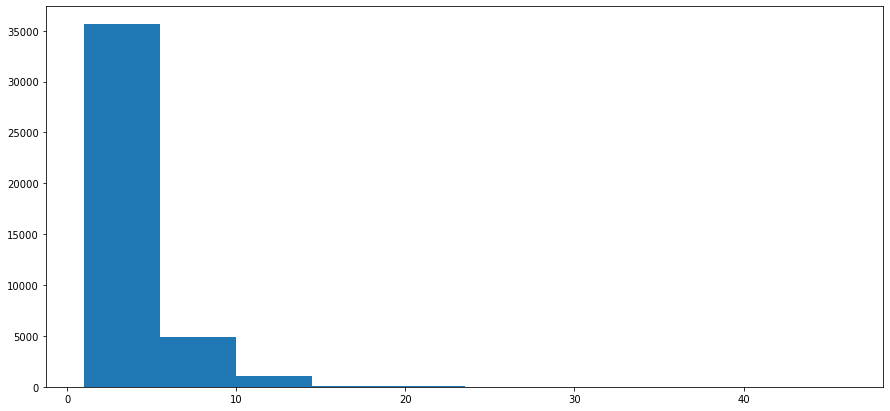

In [16]:
plt.hist([len(track) for track in tracks])

In [ ]:
len([len(track) for track in tracks if len(track) > 15])

In [ ]:
plt.hist([len(track) for track in tracks if len(track) > 7])

### Filter tracks

In [20]:
tracks_filt = [track for track in tracks if len(track) > 15]
visualise_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks_filt, ndim = 2)

In [18]:
visualise_raw_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim = 2)

In [22]:
viewer = napari.Viewer()
viewer.add_image(gfp, name="gfp", 
                 #contrast_limits=[0,255],
                 blending = 'additive', colormap = 'green')
viewer.add_image(rfp, name="rfp", 
                # contrast_limits=[0,55], 
                 blending = 'additive', colormap = 'magenta')
viewer.add_labels(masks, name = 'masks')
viewer.add_tracks(visualise_tracks, name = 'tracks_filtered')
viewer.add_tracks(visualise_raw_tracks, name = 'tracks')


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Tracks layer 'tracks' at 0x7f52a0747100>

# Troubleshooting duplicate cell localisation 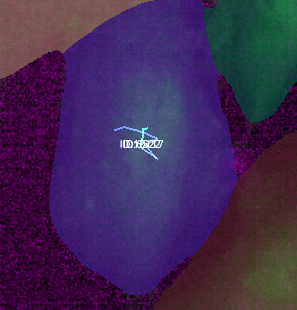

Is it because of small objects appearing in the segmentation?

In [123]:
mask = masks[0].compute()

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


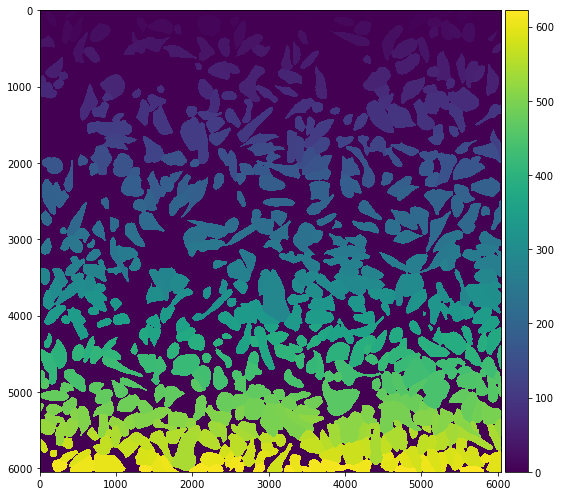

In [124]:
imshow(mask)

In [126]:
np.max(mask), np.min(mask)

(622, 0)

pixel identity values tell me that there are 621 individual masks in this image, however regions props tells me a lesser count

In [131]:
len(skimage.measure.regionprops(mask))

585

In [129]:
len(skimage.measure.regionprops(masks[0]))

585

In [130]:
len(skimage.measure.regionprops(masks[0].compute()))

585

In [149]:
import btrack

In [153]:
reload(btrack.utils)

<module 'btrack.utils' from '/home/dayn/analysis/BayesianTracker/btrack/utils.py'>

In [154]:
objects = btrack.utils.segmentation_to_objects(
    masks[0:2], 
#     image[9:11],
#     properties = tuple(FEATURES),
#     use_weighted_centroid = False, 
#     track_progress=True
)

[INFO][2022/11/11 11:53:09 am] Localizing objects from segmentation...
[INFO][2022/11/11 11:53:18 am] Objects are of type: <class 'dict'>
[INFO][2022/11/11 11:53:18 am] ...Found 2508 objects in 2 frames.


In [155]:
objects[0]

{'ID': 0, 'x': 228.89178743961352, 'y': 53.54589371980676, 'z': 0.0, 't': 0, 'dummy': False, 'states': 7, 'label': 5}

In [158]:
len([obj for obj in objects if obj.t ==0])

1278

In [161]:
xyt0 = [(int(obj.x),int(obj.y)) for obj in objects if obj.t ==0]

In [162]:
x = [xy[0] for xy in xyt0]
y = [xy[1] for xy in xyt0]

In [170]:
len(xyt0)

1278

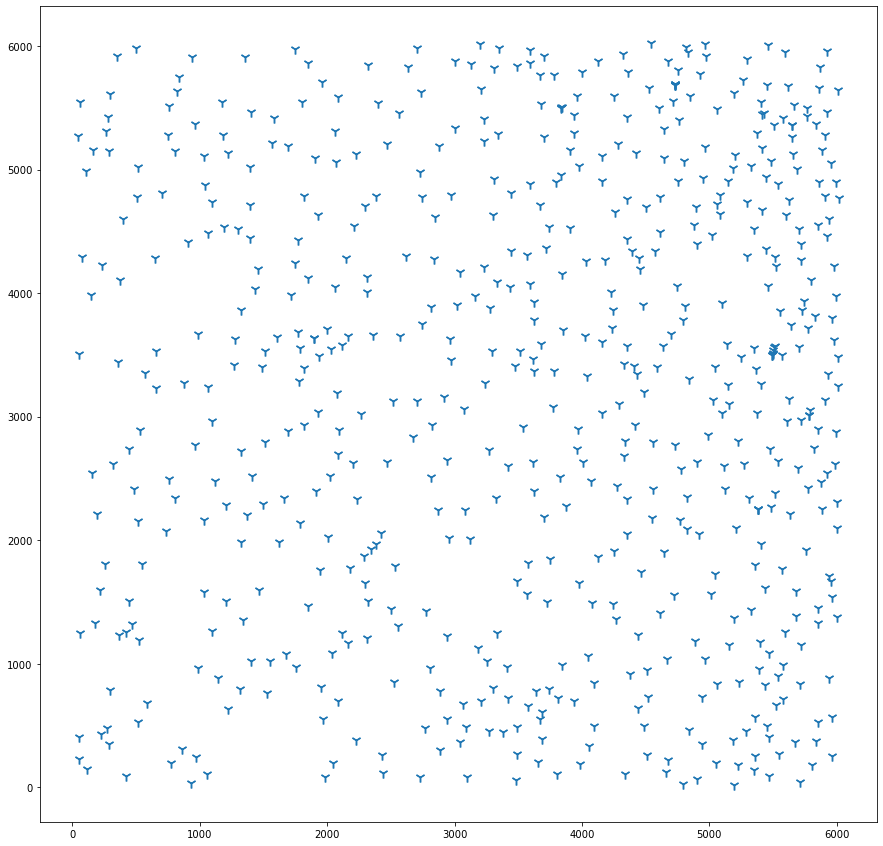

In [169]:
plt.scatter(y,x, s = 100, marker='1')

Test the number of objects in the mask versus the number of objects found in the localisation

In [55]:
masks[9:11]

dask.array<getitem, shape=(2, 6048, 6048), dtype=uint16, chunksize=(1, 2160, 2160), chunktype=numpy.ndarray>

In [65]:
n_props = 0
for mask in masks[9:11]:
    props2 = skimage.measure.regionprops(masks[11])
    n_props+=(len(props2))

In [66]:
n_props

1148

In [69]:
FEATURES = [
  "area",
  "major_axis_length",
  "minor_axis_length",
  "orientation",
  "solidity",
  "mean_intensity",
    "intensity_image"
]

In [70]:
objects = btrack.utils.segmentation_to_objects(
    masks[9:11], 
    image[9:11],
    properties = tuple(FEATURES),
    use_weighted_centroid = False, 
    track_progress=True
)

[INFO][2022/11/11 11:04:45 am] Localizing objects from segmentation...
[INFO][2022/11/11 11:04:45 am] Found intensity_image data


  0%|          | 0/2 [00:00<?, ?it/s]

[INFO][2022/11/11 11:05:28 am] Objects are of type: <class 'dict'>
[INFO][2022/11/11 11:05:28 am] ...Found 2580 objects in 2 frames.


Looks like it is finding double the objects expected...

In [71]:
objects = btrack.utils.segmentation_to_objects(
    masks[9:11], 
    image[9:11],
#     properties = tuple(FEATURES),
    use_weighted_centroid = False, 
    track_progress=True
)

[INFO][2022/11/11 11:05:51 am] Localizing objects from segmentation...
[INFO][2022/11/11 11:05:51 am] Found intensity_image data


  0%|          | 0/2 [00:00<?, ?it/s]

[INFO][2022/11/11 11:06:09 am] Objects are of type: <class 'dict'>
[INFO][2022/11/11 11:06:09 am] ...Found 2580 objects in 2 frames.


In [73]:
objects = btrack.utils.segmentation_to_objects(
    masks[9:11], 
#     image[9:11],
#     properties = tuple(FEATURES),
#     use_weighted_centroid = False, 
    track_progress=True
)

[INFO][2022/11/11 11:06:30 am] Localizing objects from segmentation...


  0%|          | 0/2 [00:00<?, ?it/s]

[INFO][2022/11/11 11:06:39 am] Objects are of type: <class 'dict'>
[INFO][2022/11/11 11:06:39 am] ...Found 2580 objects in 2 frames.


In [110]:
objects[0]

{'ID': 0, 'x': 26.941608102521702, 'y': 89.12257131045887, 'z': 0.0, 't': 0, 'dummy': False, 'states': 7, 'label': 5}

In [112]:
x, y = [], []
for obj in objects:
    if obj.t == 0:
        x.append(obj.x)
        y.append(obj.y)

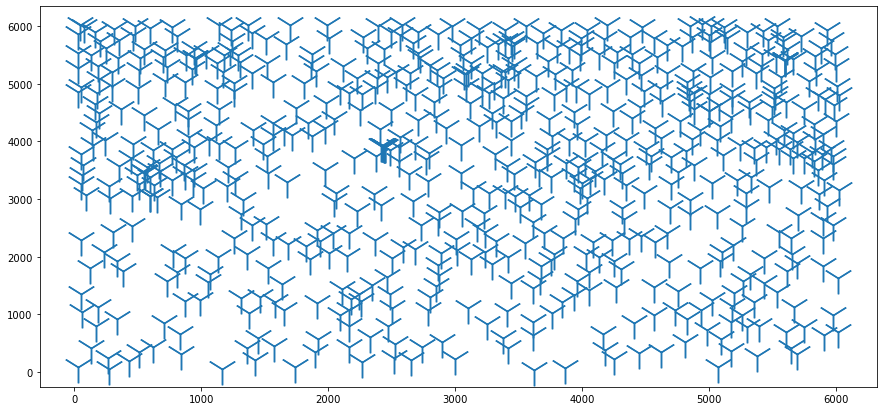

In [114]:
plt.scatter(x, y, marker='1', s = 1000)
# plt.xlim(0,5000)
# plt.ylim(0,1000)

##### Digging into the localisation code

In [145]:
from importlib import reload  # Python 3.4+
reload(btrack)

<module 'btrack' from '/home/dayn/analysis/BayesianTracker/btrack/__init__.py'>

In [93]:
from btrack import _localization as loc

In [94]:
loc.segmentation_to_objects(masks[9:11])

[INFO][2022/11/11 11:13:34 am] Localizing objects from segmentation...


  0%|          | 0/2 [00:00<?, ?it/s]

[INFO][2022/11/11 11:13:44 am] Objects are of type: <class 'dict'>
[INFO][2022/11/11 11:13:44 am] ...Found 2580 objects in 2 frames.


[{'ID': 0, 'x': 26.941608102521702, 'y': 89.12257131045887, 'z': 0.0, 't': 0, 'dummy': False, 'states': 7, 'label': 5},
 {'ID': 1, 'x': 269.2715318869165, 'y': 50.92888450580758, 'z': 0.0, 't': 0, 'dummy': False, 'states': 7, 'label': 5},
 {'ID': 2, 'x': 1166.5019578209797, 'y': 52.28474273545373, 'z': 0.0, 't': 0, 'dummy': False, 'states': 7, 'label': 5},
 {'ID': 3, 'x': 1740.7406577624588, 'y': 94.03587534108861, 'z': 0.0, 't': 0, 'dummy': False, 'states': 7, 'label': 5},
 {'ID': 4, 'x': 3619.2556727022693, 'y': 42.697685079074034, 'z': 0.0, 't': 0, 'dummy': False, 'states': 7, 'label': 5},
 {'ID': 5, 'x': 3866.0861122453607, 'y': 71.81929132072048, 'z': 0.0, 't': 0, 'dummy': False, 'states': 7, 'label': 5},
 {'ID': 6, 'x': 5066.075011633317, 'y': 89.29490460679386, 'z': 0.0, 't': 0, 'dummy': False, 'states': 7, 'label': 5},
 {'ID': 7, 'x': 429.09956532155934, 'y': 183.31125714481294, 'z': 0.0, 't': 0, 'dummy': False, 'states': 7, 'label': 5},
 {'ID': 8, 'x': 2266.2964939392477, 'y':

#### Checking featuers were measured

In [6]:
objects[0]

{'ID': 0, 'x': 228.89178743961352, 'y': 53.54589371980676, 'z': 0.0, 't': 0, 'dummy': False, 'states': 7, 'label': 5, 'area': 8280, 'major_axis_length': 142.1681837092044, 'minor_axis_length': 74.98138905075203, 'orientation': 0.7685315327700352, 'solidity': 0.9757247230732972, 'mean_intensity-0': 1223.1384057971015, 'mean_intensity-1': 337.88864734299517, 'intensity_image': array([[[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       ...,

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]]], dtype=uint16)}

In [7]:
### finding the EFD
for obj in tqdm(objects):
    ### extract the intensity image (1ch only)
    glimpse = obj.properties['intensity_image'][...,0]
    ### pad the glimpse to ensure only one object is identifiable
    glimpse = np.pad(glimpse, pad_width = 1)
    ### find the contours (zero because only one object)
    contours = skimage.measure.find_contours(glimpse, fully_connected='high', level = 0.5)[0]
    ### get the efd
    efd = elliptic_fourier_descriptors(contours, order=100, normalize=True)
#     obj.properties = {'efd': efd}
    flatten_efd = efd.flatten()
    obj.properties = {'efd flat': flatten_efd}

  0%|          | 0/69608 [00:00<?, ?it/s]

## Remove intensity image from objects 

btrack does not handle 2d arrays in objects

In [8]:
for obj in tqdm(objects):
    obj.properties.pop('intensity_image')

  0%|          | 0/69608 [00:00<?, ?it/s]

In [9]:
objects[0]

{'ID': 0, 'x': 228.89178743961352, 'y': 53.54589371980676, 'z': 0.0, 't': 0, 'dummy': False, 'states': 7, 'label': 5, 'area': 8280, 'major_axis_length': 142.1681837092044, 'minor_axis_length': 74.98138905075203, 'orientation': 0.7685315327700352, 'solidity': 0.9757247230732972, 'mean_intensity-0': 1223.1384057971015, 'mean_intensity-1': 337.88864734299517, 'efd flat': array([ 1.00000000e+00,  5.04301835e-17,  1.14701462e-16, -6.09709389e-01,
        2.01976227e-02,  8.87153725e-03, -4.89990443e-02, -2.30932987e-02,
        4.96015509e-02,  2.22684140e-03,  1.97777233e-02, -6.52375860e-02,
       -1.61762974e-03,  4.21390024e-03,  6.80647690e-04, -3.76505429e-03,
        1.05512406e-02, -4.07975839e-04,  5.86517107e-04, -9.60494084e-03,
       -6.98005603e-03,  5.03815140e-03, -9.67077973e-04,  7.75433259e-03,
        3.51114072e-03, -6.58337802e-03, -1.87062801e-03,  3.27958217e-03,
        3.22977869e-04,  8.28085673e-03,  6.93344800e-03, -2.27455131e-03,
       -1.19519206e-03, -7.04011333e-03, -4.47416433e-03,  3.10420744e-04,
        2.68803249e-03,  5.93816998e-03,  2.13798631e-03,  1.03867541e-03,
       -2.72036474e-03, -3.42627101e-03,  1.01166469e-03, -1.39096609e-03,
        1.86584384e-03,  2.29004954e-03, -2.83302613e-03, -2.34922322e-04,
       -4.72931407e-04, -1.01812765e-03,  2.81674483e-03, -7.07489089e-04,
       -1.66482600e-03,  2.02827423e-03, -1.54457356e-04, -1.29588986e-03,
        2.57490199e-03, -1.27656143e-03, -1.81186695e-03,  2.07572955e-03,
       -1.41233818e-03,  1.42119967e-03,  2.51444308e-03, -1.29947872e-04,
        1.59962205e-03, -1.33302262e-03, -9.23309588e-04,  5.43618873e-05,
        2.62620014e-04,  1.01734811e-03, -1.03857862e-03,  1.52913514e-03,
        2.00747585e-04, -1.04091945e-04,  9.12398983e-04, -1.58627506e-03,
        8.68560221e-04, -6.04671434e-04, -1.77728274e-05, -2.21296486e-04,
       -1.15549792e-04,  1.03128782e-03,  1.79668554e-04,  6.31632075e-04,
        8.51758725e-04, -1.72974649e-03,  3.90995491e-04, -7.14500934e-04,
        1.16578563e-04,  1.05820726e-03, -6.81204958e-04,  1.28597457e-03,
        7.14805518e-04, -1.04273041e-03,  1.01359713e-03, -8.47485901e-04,
       -2.51396246e-04,  7.68356581e-04,  1.64672708e-04, -1.10066311e-03,
        8.92798183e-04, -3.29990031e-04, -8.54309126e-04,  1.10377098e-03,
       -1.01218781e-03,  4.28701126e-04,  2.83842823e-04, -3.14728090e-04,
        1.01534709e-03, -1.09306163e-04, -6.17853094e-04, -6.09944737e-04,
       -5.06543474e-04,  1.79488309e-04,  1.10643996e-03,  7.61548988e-04,
        4.21945913e-04,  5.31384440e-04,  7.53410906e-04,  2.03385206e-04,
       -5.08070414e-04, -2.86505392e-04, -2.20785493e-03,  1.94249606e-04,
        3.41898620e-04,  7.15824486e-04,  3.38721489e-05, -2.49267270e-04,
       -2.64607459e-04, -2.79842118e-04,  8.67219527e-04, -4.40285781e-04,
        5.34562152e-04,  1.63838452e-04,  7.29208121e-05,  2.47532970e-04,
        5.95851673e-05, -1.30993651e-04,  1.09116154e-03,  1.81898748e-04,
       -5.89545242e-04, -4.73526996e-04, -5.71898285e-04, -6.34270107e-04,
        8.99264166e-04, -5.06610494e-05, -1.67433931e-04, -1.99754939e-04,
       -6.11627418e-04, -2.14649652e-04,  5.60688844e-04,  4.48659166e-04,
        8.48051633e-04, -7.52024107e-04, -3.13138790e-04,  5.43722767e-05,
        1.21816208e-04,  7.53054683e-05,  3.18770775e-04,  7.02679137e-04,
        2.66734339e-04,  3.98417069e-05, -7.84266023e-05,  1.75608196e-04,
        6.44278393e-04, -5.46194395e-04, -8.14276429e-04, -4.19748909e-04,
        1.01580143e-04,  6.95019509e-04,  6.63031624e-04,  2.85621415e-04,
        1.87573001e-04, -6.32407813e-04, -1.13149742e-03, -3.78375538e-04,
        2.62121041e-04,  8.45593956e-04, -1.95384741e-05, -6.14103573e-04,
       -7.96252846e-05, -5.94504741e-05,  5.02920925e-04,  8.19084506e-04,
       -6.12751645e-05,  1.25976584e-04, -3.80003191e-04, -1.20860318e-03,
        1.44873222e-04,  6.53646454e-04,  8.17380757e-04, -2.40791973e-04,
       -8.20519315e-04, -1.57

## Track

Redefine features to include `efd flat` and the two different `mean_intensity` channels

In [12]:
FEATURES = ['efd flat',
                     "area",
  "major_axis_length",
  "minor_axis_length",
  "orientation",
  "solidity",
  "mean_intensity-0",
  "mean_intensity-1",
]